<a href="https://colab.research.google.com/github/DanBaissa/Symbolic-Distillation/blob/main/symbolic_distillation_bert.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🧠 Symbolic Distillation of BERT Predictions in Google Colab

This notebook demonstrates how to distill the predictions of a powerful BERT-based sentiment classifier into a set of interpretable token-level features. The goal is to understand and approximate the behavior of the black-box model using simple, human-readable attributes like part-of-speech (POS) tags and token identities. We extract features from text using NLTK, apply a pre-trained DistilBERT model to generate sentiment predictions, and construct a labeled dataset combining raw inputs, predicted outputs, and true sentiment labels. Finally, we evaluate the performance of the predictions and upload the results to a GitHub repository.

## 1a. GitHub Upload Setup

This section sets up Git to push notebook outputs to your GitHub repository. It uses a personal access token (retrieved securely via Colab's `userdata`) to authenticate and push code and results automatically.

In [ ]:
from google.colab import userdata

# Get token
token = userdata.get('Colab_token')

# Clone
!git clone https://github.com/DanBaissa/Symbolic-Distillation.git

# Change into the directory
%cd Symbolic-Distillation

# Set remote to use token (for pushing)
!git remote set-url origin https://{token}@github.com/DanBaissa/Symbolic-Distillation.git
# remote_url = f"https://{token}@github.com/DanBaissa/Symbolic-Distillation.git"
# !git remote set-url origin "$remote_url"

# Set Git config (only needs to be done once per session)
!git config --global user.email "danbaissa@gmail.com"
!git config --global user.name "Dan Baissa"


Cloning into 'Symbolic-Distillation'...
remote: Enumerating objects: 3, done.
remote: Counting objects: 100% (3/3), done.
remote: Total 3 (delta 0), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (3/3), done.
/content/Symbolic-Distillation


## 1b. Installation

This section installs all necessary packages, including Hugging Face Transformers, NLTK, and other dependencies used for loading models, processing text, and visualizing results.

In [ ]:
!pip install -q -U transformers pandas scikit-learn tqdm datasets huggingface_hub fsspec nltk

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.2/91.2 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 60.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.7/9.7 MB 52.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 494.8/494.8 kB 20.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 9.7 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 2.3.1 which is incompatible.
sklearn-compat 0.1.3 requires scikit-learn<1.7,>=1.2, but you have scikit-learn 1.7.1 which is incompatible.
gcsfs 2025.3.2 requires fsspec==2025.3.2, but you have fsspec 2025.3.0 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nv

## 2. Load Other Imports and Models

We import key libraries, download NLTK models for tokenization and POS tagging, and initialize the DistilBERT sentiment analysis pipeline. We also define helper functions to tokenize words and safely make predictions.

In [ ]:
import nltk
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('averaged_perceptron_tagger')
nltk.download('averaged_perceptron_tagger_eng')  # Fix for Colab issue
from nltk import word_tokenize, pos_tag
from transformers import AutoTokenizer, pipeline

# Load BERT tokenizer
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased-finetuned-sst-2-english")

# Token ID helper
def token_id(word):
    tokens = tokenizer.tokenize(word)
    return tokenizer.convert_tokens_to_ids(tokens[0]) if tokens else 0

# Load sentiment classifier
sentiment_model = pipeline("sentiment-analysis", model="distilbert-base-uncased-finetuned-sst-2-english")

def safe_predict(text):
    try:
        return sentiment_model(text)[0]
    except:
        return {"label": "NEGATIVE", "score": 0.0}

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger_eng.zip.
/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:104: UserWarning: 
Error while fetching `HF_TOKEN` secret value from your vault: 'Requesting secret HF_TOKEN timed out. Secrets can only be fetched when running from the Colab UI.'.
You are not authenticated with the Hugging Face Hub in this notebook.
If the error persists, please let us know by opening an issue on GitHub (https://github.com/huggingface/huggingface_hub/issues/

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Device set to use cuda:0


## 3. Test POS Tagging

This diagnostic section demonstrates POS tagging on a sample sentence using NLTK. It prints each word along with its part-of-speech label, confirming that tagging is working properly.

In [ ]:
sentence = "The quick brown fox jumps over the lazy dog."
tokens = word_tokenize(sentence)
tags = pos_tag(tokens)
for word, tag in tags:
    print(f"{word:10s} {tag}")

The        DT
quick      JJ
brown      NN
fox        NN
jumps      VBZ
over       IN
the        DT
lazy       JJ
dog        NN
.          .


## 4. Feature Extraction Using Trankit

This section defines a function to extract interpretable token-level features from a sentence. It captures the positions and token IDs of up to 3 adjectives, 2 nouns, and 2 verbs, forming a structured feature set for each input.

In [ ]:
def extract_features(sentence):
    tokens = word_tokenize(sentence)
    tags = pos_tag(tokens)

    features = {"text": sentence}
    adjs, nouns, verbs = [], [], []

    for i, (word, tag) in enumerate(tags):
        if tag.startswith("JJ") and len(adjs) < 3:
            adjs.append((i+1, token_id(word)))
        elif tag.startswith("NN") and len(nouns) < 2:
            nouns.append((i+1, token_id(word)))
        elif tag.startswith("VB") and len(verbs) < 2:
            verbs.append((i+1, token_id(word)))

    adjs += [(0, 0)] * (3 - len(adjs))
    nouns += [(0, 0)] * (2 - len(nouns))
    verbs += [(0, 0)] * (2 - len(verbs))

    for j, (pos, tid) in enumerate(adjs):
        features[f"adj{j+1}_pos"], features[f"adj{j+1}_id"] = pos, tid
    for j, (pos, tid) in enumerate(nouns):
        features[f"noun{j+1}_pos"], features[f"noun{j+1}_id"] = pos, tid
    for j, (pos, tid) in enumerate(verbs):
        features[f"verb{j+1}_pos"], features[f"verb{j+1}_id"] = pos, tid

    return features

## 5. Build Feature DataFrame

This section builds a DataFrame by applying the feature extraction method to IMDb movie reviews, predicts sentiment using DistilBERT, and saves the resulting structured features. The output includes both the BERT model's prediction (`y_est`) and the ground truth sentiment (`y_true`). The final DataFrame is saved as a CSV file in a `data` folder within your GitHub repository for future analysis or sharing.

In [ ]:
from datasets import load_dataset
from tqdm import tqdm

# Load and sample IMDb dataset
data = load_dataset("imdb", split="train", cache_dir="/content/imdb_cache")
data = data.shuffle(seed=42).select(range(20000))

sentences = data["text"]
labels = [2 * l - 1 for l in data["label"]]  # Convert 0/1 to -1/+1

rows = []
for i, sent in tqdm(enumerate(sentences)):
    feats = extract_features(sent)
    label = safe_predict(sent)  # your BERT inference function
    feats["y_est"] = label["score"] if label["label"] == "POSITIVE" else -label["score"]
    feats["y_true"] = labels[i]
    rows.append(feats)

import pandas as pd
df = pd.DataFrame(rows)

# Save to GitHub data folder
import os
os.makedirs("data", exist_ok=True)
df.to_csv("data/sentiment_features.csv", index=False)
df.head()

README.md: 0.00B [00:00, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/21.0M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/20.5M [00:00<?, ?B/s]

unsupervised-00000-of-00001.parquet:   0%|          | 0.00/42.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

1it [00:00,  2.25it/s]Token indices sequence length is longer than the specified maximum sequence length for this model (936 > 512). Running this sequence through the model will result in indexing errors
10it [00:00, 17.90it/s]You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
20000it [06:23, 52.11it/s]


,text,adj1_pos,adj1_id,adj2_pos,adj2_id,adj3_pos,adj3_id,noun1_pos,noun1_id,noun2_pos,noun2_id,verb1_pos,verb1_id,verb2_pos,verb2_id,y_est,y_true
0,There is no relation at all between Fortier an...,17,2610,20,6355,29,4438,4,7189,8,3481,2,2003,16,2024,0.996812,1
1,This movie is a great. The plot is very true t...,5,2307,11,2995,18,4438,2,3185,8,5436,3,2003,9,2003,0.999873,1
2,"George P. Cosmatos' ""Rambo: First Blood Part I...",14,5760,15,4299,37,10047,1,2577,2,1052,13,2003,21,2106,0.996462,-1
3,In the process of trying to establish the audi...,41,17657,55,2219,67,2576,3,2832,9,9501,5,2667,7,5323,-0.997399,1
4,"Yeh, I know -- you're quivering with excitemen...",33,4895,35,3606,37,10634,1,6300,10,8277,4,2113,7,1005,-0.000000,-1


## 6. Evaluate with Confusion Matrix and F1 Score

We evaluate how closely the symbolic feature-based predictions match the original DistilBERT model. This section binarizes the predicted and true labels, then calculates the confusion matrix and F1 score for performance assessment.

F1 Score: 0.8189473684210526


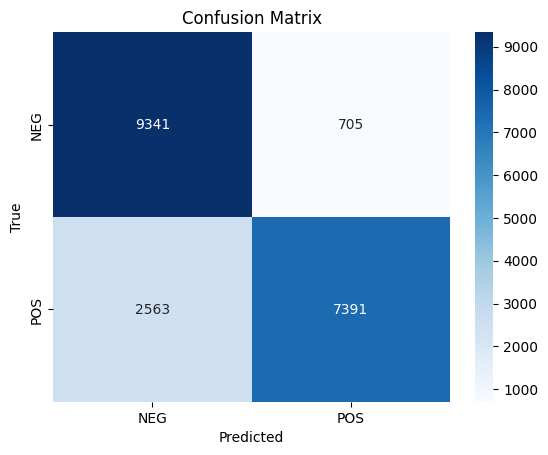

In [ ]:
from sklearn.metrics import confusion_matrix, f1_score
import seaborn as sns
import matplotlib.pyplot as plt

# Convert predictions and labels to 0 and 1
y_pred = (df["y_est"] > 0).astype(int)
y_true = (df["y_true"] > 0).astype(int)

# Compute confusion matrix and F1
cm = confusion_matrix(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

# Display
print("F1 Score:", f1)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["NEG", "POS"], yticklabels=["NEG", "POS"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
# Push results to GitHub
# This final block stages the changes (like CSVs), commits them with a message, and pushes to GitHub.
# Ensure that you have appropriate write access through your personal token.
# This will stage all changes, commit with a standard message, and push to the main branch.
# Make sure your Colab_token has push access to the repository.
# Disable credential helper to avoid interactive prompt
!git config --global --unset credential.helper || true
!git config --global credential.helper ""


!git add .
!git commit -m "Auto push from Jupyter"
!git push origin main

[main 41836cb] Auto push from Jupyter
 1 file changed, 20001 insertions(+)
 create mode 100644 data/sentiment_features.csv
Enumerating objects: 5, done.
Counting objects: 100% (5/5), done.
Delta compression using up to 2 threads
Compressing objects: 100% (4/4), done.
Writing objects: 100% (4/4), 11.17 MiB | 2.93 MiB/s, done.
Total 4 (delta 0), reused 0 (delta 0), pack-reused 0
To https://github.com/DanBaissa/Symbolic-Distillation.git
   7e300e6..41836cb  main -> main
